## 1. 필요한 패키지 불러오기

In [135]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow import keras
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from konlpy.tag import Mecab
from collections import defaultdict
from tensorflow.keras.initializers import Constant
import gensim

## 2. 데이터 가져오기

In [2]:
train_data = pd.read_table("./data/ratings_train.txt")
test_data = pd.read_table("./data/ratings_test.txt")

In [3]:
train_row = train_data.shape[0]
train_col = train_data.shape[1]
print(f"훈련 데이터 개수 : {train_row}\n훈련 데이터셋 칼럼 : {train_col}")

test_row = test_data.shape[0]
test_col = test_data.shape[1]
print(f"훈련 데이터 개수 : {test_row}\n훈련 데이터셋 칼럼 : {test_col}")


print(f"칼럼명 : {list(train_data.columns)}")
train_data.head()

훈련 데이터 개수 : 150000
훈련 데이터셋 칼럼 : 3
훈련 데이터 개수 : 50000
훈련 데이터셋 칼럼 : 3
칼럼명 : ['id', 'document', 'label']


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 3. 데이터 살펴보기 및 전처리 (1)

- 데이터 중복 제거
- NaN 결측치 제거
- 데이터 살펴보기
- ~너무 긴 문장 제거하기~

### 중복 데이터 제거

In [4]:
# https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/
train_data = train_data.drop_duplicates("document", keep="first")
print(f"중복 제거 후 훈련 데이터 개수 : {len(train_data)}")

중복 제거 후 훈련 데이터 개수 : 146183


### 결측치 제거

In [5]:
train_data[train_data["document"].isnull()]

,id,document,label
25857,2172111,NaN,1


In [6]:
train_data = train_data[train_data["document"].isnull() == False]
print(f"결측치 제거 후 훈련 데이터 개수 : {len(train_data)}")

결측치 제거 후 훈련 데이터 개수 : 146182


In [7]:
train_data = train_data.reset_index().drop(columns = ["index"])
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
146177,6222902,인간이 문제지.. 소는 뭔죄인가..,0
146178,8549745,평점이 너무 낮아서...,1
146179,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
146180,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### 데이터 살펴보기

In [8]:
train_data.groupby("label").count()["id"]

label
0    73342
1    72840
Name: id, dtype: int64

긍정 라벨인 1과 부정 라벨인 0의 개수는 서로 72000개 이상으로 비슷한 비율을 가지고 있습니다.

In [9]:
train_data.groupby("id").count().sum()

document    146182
label       146182
dtype: int64

In [10]:
train_data.groupby("id").count().sum()["label"] == len(train_data)

True

전체 데이터의 개수와 id의 개수가 동일한 것으로 보아하니 해당 데이터셋의 모든 문장은 모두 다른 id가 작성한 것을 알 수가 있습니다.

동일한 id가 서로 다른 문장을 작성한 경우는 없습니다.

In [11]:
train_data["length"] = train_data["document"].apply(lambda x : len(x))
train_data

,id,document,label,length
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,17
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61
...,...,...,...,...
146177,6222902,인간이 문제지.. 소는 뭔죄인가..,0,19
146178,8549745,평점이 너무 낮아서...,1,13
146179,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0,31
146180,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1,27


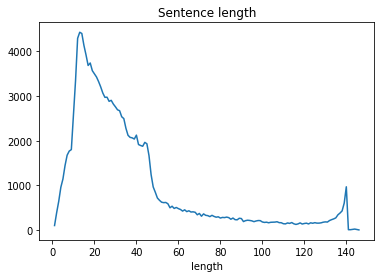

In [12]:
train_data.groupby("length").count()["id"].plot()
plt.title("Sentence length")
plt.show()

In [229]:
train_data[train_data["length"] > 100]["document"]

22        재미없다 지루하고. 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남....바베트의...
46        리얼리티가 뛰어나긴 한데 큰 공감은 안간다. 이민기캐릭터는 정신의학상 분노조절장애 ...
49        데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다...
57        너무 충격적이엇다. 기분을 완전히 푹 꺼지게 하는 느낌... 활력이라고는 하나도 없...
65        많은 사람들이 이 다큐를 보고 우리나라 슬픈 현대사의 한 단면에 대해 깊이 생각하고...
                                ...                        
146148    성룡의진중하고 무게있는 연기가 참좋다. 신주쿠-대병소장-베스트키드-스파이넥스트도어-...
146159    일본은 한국전쟁에 참전한적도 없고 2차세계대전이후 완전 패망했다가 한국전쟁 때 군수...
146161    그리 만족스럽진못했어도 7점은 나와야되는것같아 10점줌. 주인공들연기도 훌륭했고 내...
146164    시간이 아깝다. 어린 여주의 연기는 인상적이었고 나중이 기대되어서 좋았고 남주 여주...
146173    http://blog.naver.com/oroblast/220215679580 나쁜...
Name: document, Length: 8684, dtype: object

주로 문장의 길이는 10~20 사이이며 140이상의 경우가 이상치라고 판단할 수 있을까 확인해본 결과 오히려 긴 문장에 담긴 단어들이 더 감정을 잘 표현한 경우가 많아서 모두 포함해도 괜찮다고 판단했습니다.

### ~너무 긴 문장 제거하기~ - 사용가능한 아이디어지만 성능이 떨어지게됨

차라리 가징 긴 문장을 기준으로 패딩을 진행하겠습니다.

In [13]:
maxlen = max(train_data["length"])
print(f"가장 긴 문장의 길이 : {maxlen}")

가장 긴 문장의 길이 : 146


In [105]:
# train_data[train_data["length"] > 100]

In [106]:
# maxlen = int(np.std(train_data.length) * 2 + np.mean(train_data.length))
# print(f"평균으로부터 2표준편차 이내의 문장 길이 : {maxlen}")

In [107]:
# print(f"긴 문장 제거 전 : {len(train_data)}")
# train_data = train_data.loc[train_data["length"] <= maxlen, :]
# train_data = train_data.reset_index().drop(columns=["index"])
# print(f"긴 문장 제거 후 : {len(train_data)}")

## 4. 텍스트 데이터 토큰화 및 임베딩 (2)

- 한국어 토크나이저로 토큰화
- 불용어 제거
- word_to_index 사전 구성
- 텍스트를 라벨 인덱스로 변환

### 한국어 토크나이저로 토큰화 & 불용어 제거

In [14]:
def tokenization(corpus, tokenizer):
    # https://pypi.org/project/python-mecab-ko/
    
    # 특수문자 제거
    corpus = re.sub("[^ㄱ-ㅎ가-힣0-9A-Za-z]", " ", corpus)
    corpus = re.sub("[ ]+", " ", corpus)
    corpus = corpus.strip()
    
    # 토큰화
    tokens = tokenizer.morphs(corpus)
    
    # 불용어 제거
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    tokens = [word for word in tokens if word not in stopwords]
    
    return tokens        

In [15]:
tokenizer = Mecab()

tqdm.pandas()
train_data["tokenization"] = train_data["document"].progress_apply(lambda x : tokenization(x, tokenizer))

100%|██████████| 146182/146182 [00:17<00:00, 8232.82it/s]


In [16]:
train_data["token_length"] = train_data["tokenization"].apply(lambda x: len(x))
# https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
token_train_data = train_data.loc[(train_data["token_length"] > 0), :]
token_train_data = token_train_data.reset_index().drop(columns=["index"])
print(f"비어있는 데이터 제거 후 데이터 개수 : {len(token_train_data)}")

비어있는 데이터 제거 후 데이터 개수 : 146040


### word_to_index 사전 구성

In [17]:
token_data = token_train_data["tokenization"]
word_num = defaultdict()

for token_one in token_data:
    for word in token_one:
        if word in word_num:
            word_num[word] += token_one.count(word)
        else:
            word_num[word] = token_one.count(word)

word_num = sorted(dict(word_num).items(), key = lambda x: x[1], reverse = True)
words = [i for i, j in word_num]

In [18]:
word_index = dict()
index_word = dict()

word_index["<pad>"] = 0
word_index["<bos>"] = 1
word_index["<unk>"] = 2
word_index["<unused>"] = 3

index_word[0] = "<pad>"
index_word[1] = "<bos>"
index_word[2] = "<unk>"
index_word[3] = "<unused>"

for ind, word in enumerate(words):
    word_index[word] = ind + 4
    index_word[ind + 4] = word

### 텍스트를 라벨 인덱스로 변환

In [156]:
def text_sequence(token_data, maxlen, num_word):
    # 텍스트 데이터를 시퀀스 데이터로 변환
    encode_data = []
    dictionary = dict(list(word_index.items())[:num_word])
    for data in token_data:
        tmp = []
        for word in data:
            if word in dictionary:
                tmp += [word_index[word]]
            else:
                tmp += [word_index["<unk>"]]
        encode_data += [tmp]
    # 시퀀스 데이터 일정한 길이로 패딩
    padded_data = pad_sequences(encode_data, value = word_index["<pad>"], padding = "pre", maxlen = maxlen)
    return padded_data

padded_data = text_sequence(token_data, maxlen, len(word_index))
padded_data

array([[    0,     0,     0, ...,    16,    30,   693],
       [    0,     0,     0, ...,    12,    42,   385],
       [    0,     0,     0, ...,    19,   206, 29321],
       ...,
       [    0,     0,     0, ..., 11828,  2889,     5],
       [    0,     0,     0, ...,    56,   391,  8814],
       [    0,     0,     0, ...,    84,  2858,     4]], dtype=int32)

In [157]:
print(f"전치리 완료된 문장의 개수 : {padded_data.shape[0]}")
print(f"문장의 길이 : {padded_data.shape[1]}")
print(f"단어의 갯수 : {np.max(padded_data) + 1}")

전치리 완료된 문장의 개수 : 146040
문장의 길이 : 146
단어의 갯수 : 50763


## 5. 긍정/부정 텍스트 분류모델 구축

In [164]:
X = padded_data
Y = np.array(token_train_data["label"])
X.shape, Y.shape

((146040, 146), (146040,))

In [165]:
np.random.seed(200)
random_index = np.random.choice(range(len(X)), 10000)
mini_X = X[random_index]
mini_Y = Y[random_index]

In [166]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 300)
#x_train, x_test, y_train, y_test = train_test_split(mini_X, mini_Y, test_size = 0.2, random_state = 300)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((116832, 146), (116832,), (29208, 146), (29208,))

In [167]:
vocab_size = np.max(x_train) + 1
word_vector_dim = 200
hidden_size = 16
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1)
epoch_num = 10

### simpleRNN model - Subclassing

[기본적인 SimpleRNN 구조 참고 사이트](https://aciddust.github.io/blog/post/Keras-%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D-%EC%9D%B4%ED%95%B4/)

In [168]:
class TextGenerator(tf.keras.Model):
    def __init__(self,vocab_size, embedding_size,hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True))
        self.rnn_2 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size))
        self.linear1 = tf.keras.layers.Dense(16, activation = "relu")
        self.linear2 = tf.keras.layers.Dense(1, activation = "sigmoid")
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear1(out)
        out = self.linear2(out)
        
        return out

rnn_model = TextGenerator(vocab_size, word_vector_dim, hidden_size)

In [169]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
rnn_history = rnn_model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    batch_size = 256,
    callbacks = [es],
    epochs = epoch_num)

Epoch 1/10
366/366 [==============================] - 113s 300ms/step - loss: 0.4724 - accuracy: 0.7759 - val_loss: 0.4153 - val_accuracy: 0.8179
Epoch 2/10
366/366 [==============================] - 109s 297ms/step - loss: 0.3019 - accuracy: 0.8771 - val_loss: 0.4043 - val_accuracy: 0.8303
Epoch 3/10
366/366 [==============================] - 107s 292ms/step - loss: 0.1813 - accuracy: 0.9327 - val_loss: 0.4542 - val_accuracy: 0.8235


default - 문장 길이 146, 데이터 개수 10,000, 단어의 개수 20,000 은닉 사이즈 16, 임베딩 사이즈 200

Epoch 5/10
457/457 [==============================] - 89s 196ms/step - loss: 0.6539 - accuracy: 0.5347 - val_loss: 0.6815 - val_accuracy: 0.5236
데이터 개수 full, 단어의 개수 full

Epoch 4/10
32/32 [==============================] - 5s 146ms/step - loss: 0.6683 - accuracy: 0.5341 - val_loss: 0.6730 - val_accuracy: 0.5237  
문장길이 94 데이터 개수 10,000

Epoch 3/5
32/32 [==============================] - 5s 143ms/step - loss: 0.6877 - accuracy: 0.5097 - val_loss: 0.6901 - val_accuracy: 0.5148

Epoch 1/5
32/32 [==============================] - 7s 155ms/step - loss: 0.6929 - accuracy: 0.5040 - val_loss: 0.6918 - val_accuracy: 0.5024  
rnn - activation relu

Epoch 2/5
25/25 [==============================] - 6s 244ms/step - loss: 0.4448 - accuracy: 0.8395 - val_loss: 0.4940 - val_accuracy: 0.7731  
tf.keras.layers.Bidirectional

처음에는 Conv1D모델은 제대로 학습이 일어났지만 RNN모델과 LSTM모델이 제대로 학습이 진행되지 않는 문제가 발생하였습니다.  
하지만 [텐서플로우 공식문서의 튜토리얼 예재](https://www.tensorflow.org/text/tutorials/text_classification_rnn)를 통하여 ```Bidirectional()```함수를 사용하면 학습이 진행되는 것을 확인하였습니다.

### 1-D conv1 model - Sequential API

In [170]:
conv1_model = keras.Sequential()
conv1_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
conv1_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1_model.add(keras.layers.MaxPooling1D(5))
conv1_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1_model.add(keras.layers.GlobalMaxPooling1D())
conv1_model.add(keras.layers.Dense(8, activation='relu'))
conv1_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
conv1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 200)         10152600  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_63 (Dense)             (None, 1)                

In [171]:
conv1_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
conv1_history = conv1_model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size = 256,
    callbacks = [es],
    epochs = epoch_num)

Epoch 1/10
457/457 [==============================] - 139s 304ms/step - loss: 0.4170 - accuracy: 0.7940 - val_loss: 0.3381 - val_accuracy: 0.8528
Epoch 2/10
457/457 [==============================] - 131s 287ms/step - loss: 0.2532 - accuracy: 0.8992 - val_loss: 0.3402 - val_accuracy: 0.8549


default - 문장 길이 146, 데이터 개수 10,000, 단어의 개수 20,000 은닉 사이즈 16, 임베딩 사이즈 200

Epoch 1/10
457/457 [==============================] - 61s 132ms/step - loss: 0.5016 - accuracy: 0.7401 - val_loss: 0.3371 - val_accuracy: 0.8527  
데이터 개수 full, 단어의 개수 full

Epoch 4/10
32/32 [==============================] - 7s 221ms/step - loss: 0.5010 - accuracy: 0.7949 - val_loss: 0.5308 - val_accuracy: 0.7230  
문장길이 94

### LSTM model - 함수형 API

In [172]:
inputs = tf.keras.layers.Input(shape=(x_train.shape[1]))
layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)
layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))(layer)
layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))(layer)
layer = tf.keras.layers.Dense(16, activation = "relu")(layer)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(layer)
lstm_model = tf.keras.Model(inputs, outputs)
lstm_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 146)]             0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 146, 200)          10152600  
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 146, 32)           27776     
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 146, 32)           6272      
_________________________________________________________________
dense_64 (Dense)             (None, 146, 16)           528       
_________________________________________________________________
dense_65 (Dense)             (None, 146, 1)            17        
Total params: 10,187,193
Trainable params: 10,187,193
Non-trainable params: 0
_______________________________________________

In [173]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
lstm_history = lstm_model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size = 256,
    callbacks = [es],
    epochs = epoch_num)

Epoch 1/10
457/457 [==============================] - 242s 517ms/step - loss: 0.4981 - accuracy: 0.7656 - val_loss: 0.4167 - val_accuracy: 0.7984
Epoch 2/10
457/457 [==============================] - 234s 512ms/step - loss: 0.4051 - accuracy: 0.8317 - val_loss: 0.4589 - val_accuracy: 0.7472


default - 문장 길이 146, 데이터 개수 10,000, 단어의 개수 20,000 은닉 사이즈 16, 임베딩 사이즈 200


Epoch 10/10
457/457 [==============================] - 58s 127ms/step - loss: 0.6448 - accuracy: 0.5395 - val_loss: 0.7037 - val_accuracy: 0.5235  
데이터 개수 full, 단어의 개수 full

Epoch 5/10
32/32 [==============================] - 9s 269ms/step - loss: 0.6591 - accuracy: 0.5447 - val_loss: 0.6793 - val_accuracy: 0.5226
문장길이 94

Epoch 3/5
32/32 [==============================] - 15s 459ms/step - loss: 0.4638 - accuracy: 0.8195 - val_loss: 0.5224 - val_accuracy: 0.7887  
tf.keras.layers.Bidirectional

## 6. 완성된 모델 성능 확인

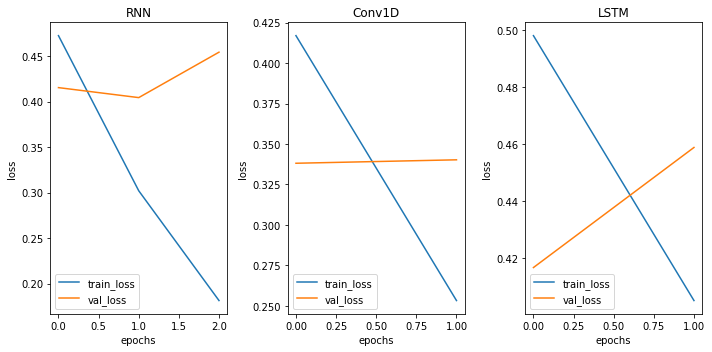

In [174]:
models = [rnn_history, conv1_history, lstm_history]
names = ["RNN", "Conv1D", "LSTM"]

fig, axes = plt.subplots(1, 3, figsize = (10, 5))
axes = axes.ravel()

for ind, axis in enumerate(axes):
    tmp = models[ind].history
    loss = tmp["loss"]
    val_loss = tmp["val_loss"]
    axis.plot(loss, label = "train_loss")
    axis.plot(val_loss, label = "val_loss")
    axis.set_title(names[ind])
    axis.set_xlabel("epochs")
    axis.set_ylabel("loss")

    axis.legend(loc = "lower left")
    
plt.tight_layout()
plt.show()

## 7. 임베딩 벡터 전이학습 적용

In [175]:
word2vec_path = './model/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사람']
vector.shape     # 무려 300dim의 워드 벡터입니다.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(200,)

In [176]:
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_word[i]]
embedding_matrix.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(50763, 200)

사전에 학습된 워드임베딩 모델를 gensim패키지로 불러오려고 하자 AttributeError: 'Word2Vec' object has no attribute 'vocabulary' 에러가 발생하였습니다. 

아지트에 올라와있는 [링크](https://iambeginnerdeveloper.tistory.com/41)를 참고하여 해결하였습니다.

## 8. 전이학습 전과 후의 모델 비교

### simpleRNN model - Subclassing

In [177]:
class TextGenerator(tf.keras.Model):
    def __init__(self,vocab_size, embedding_size,hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                   embedding_size,
                                                   embeddings_initializer=Constant(embedding_matrix),
                                                   trainable=True,
                                                   input_length=maxlen
                                                  )
        self.rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True))
        self.rnn_2 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size))
        self.linear1 = tf.keras.layers.Dense(8, activation = "relu")
        self.linear2 = tf.keras.layers.Dense(1, activation = "sigmoid")
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear1(out)
        out = self.linear2(out)
        
        return out

tuned_rnn_model = TextGenerator(vocab_size, word_vector_dim, hidden_size)

In [178]:
tuned_rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
tuned_rnn_history = tuned_rnn_model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size = 256,
    callbacks = [es],
    epochs = epoch_num)

Epoch 1/10
457/457 [==============================] - 141s 302ms/step - loss: 0.5153 - accuracy: 0.7369 - val_loss: 0.4187 - val_accuracy: 0.8122
Epoch 2/10
457/457 [==============================] - 137s 301ms/step - loss: 0.3593 - accuracy: 0.8484 - val_loss: 0.3834 - val_accuracy: 0.8350
Epoch 3/10
457/457 [==============================] - 137s 301ms/step - loss: 0.2913 - accuracy: 0.8839 - val_loss: 0.3744 - val_accuracy: 0.8402
Epoch 4/10
457/457 [==============================] - 137s 300ms/step - loss: 0.2423 - accuracy: 0.9078 - val_loss: 0.3989 - val_accuracy: 0.8407


Epoch 3/10
457/457 [==============================] - 90s 196ms/step - loss: 0.6717 - accuracy: 0.5279 - val_loss: 0.6745 - val_accuracy: 0.5272

Epoch 8/10
32/32 [==============================] - 8s 262ms/step - loss: 0.2231 - accuracy: 0.9186 - val_loss: 0.6058 - val_accuracy: 0.7520  
Bidirectional

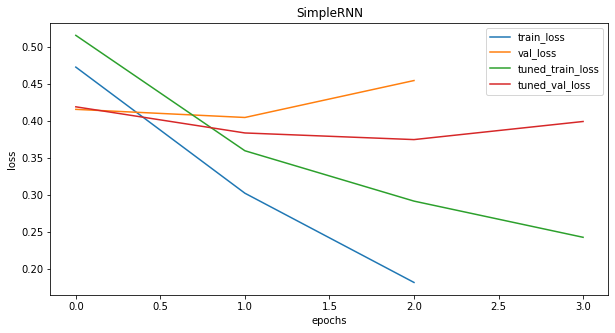

In [179]:
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history["loss"], label = "train_loss")
plt.plot(rnn_history.history["val_loss"], label = "val_loss")
plt.plot(tuned_rnn_history.history["loss"], label = "tuned_train_loss")
plt.plot(tuned_rnn_history.history["val_loss"], label = "tuned_val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("SimpleRNN")
plt.show()

### 1-D conv1 model - Sequential API

In [180]:
tuned_conv1_model = keras.Sequential()
tuned_conv1_model.add(keras.layers.Embedding(vocab_size, 
                                       word_vector_dim, 
                                       embeddings_initializer=Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                                       trainable=True, # trainable을 True로 주면 Fine-tuning
                                       input_length=maxlen))
tuned_conv1_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
tuned_conv1_model.add(keras.layers.MaxPooling1D(5))
tuned_conv1_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
tuned_conv1_model.add(keras.layers.GlobalMaxPooling1D())
tuned_conv1_model.add(keras.layers.Dense(8, activation='relu'))
tuned_conv1_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
tuned_conv1_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 146, 200)          10152600  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 140, 16)           22416     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 28, 16)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 16)            1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                

In [181]:
tuned_conv1_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
tuned_conv1_history = tuned_conv1_model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size = 256,
    callbacks = [es],
    epochs = epoch_num)

Epoch 1/10
457/457 [==============================] - 140s 304ms/step - loss: 0.5513 - accuracy: 0.6870 - val_loss: 0.4181 - val_accuracy: 0.8093
Epoch 2/10
457/457 [==============================] - 138s 302ms/step - loss: 0.3587 - accuracy: 0.8446 - val_loss: 0.3711 - val_accuracy: 0.8380
Epoch 3/10
457/457 [==============================] - 138s 303ms/step - loss: 0.2932 - accuracy: 0.8799 - val_loss: 0.3643 - val_accuracy: 0.8424
Epoch 4/10
457/457 [==============================] - 139s 303ms/step - loss: 0.2476 - accuracy: 0.9041 - val_loss: 0.3752 - val_accuracy: 0.8435


Epoch 4/10
457/457 [==============================] - 55s 121ms/step - loss: 0.2466 - accuracy: 0.9042 - val_loss: 0.3738 - val_accuracy: 0.8434

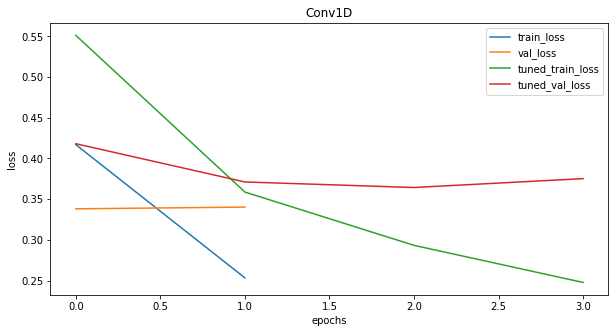

In [182]:
plt.figure(figsize=(10,5))
plt.plot(conv1_history.history["loss"], label = "train_loss")
plt.plot(conv1_history.history["val_loss"], label = "val_loss")
plt.plot(tuned_conv1_history.history["loss"], label = "tuned_train_loss")
plt.plot(tuned_conv1_history.history["val_loss"], label = "tuned_val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Conv1D")
plt.show()

### LSTM model - 함수형 API

In [183]:
inputs = tf.keras.layers.Input(shape=(x_train.shape[1]))
layer = tf.keras.layers.Embedding(vocab_size, 
                                       word_vector_dim, 
                                       embeddings_initializer=Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                                       trainable=True, # trainable을 True로 주면 Fine-tuning
                                       input_length=maxlen)(inputs)
layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True))(layer)
layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size))(layer)
layer = tf.keras.layers.Dense(16, activation = "relu")(layer)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(layer)
tuned_lstm_model = tf.keras.Model(inputs, outputs)
tuned_lstm_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 146)]             0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 146, 200)          10152600  
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 146, 32)           27776     
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dense_70 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 17        
Total params: 10,187,193
Trainable params: 10,187,193
Non-trainable params: 0
_______________________________________________

In [184]:
tuned_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
tuned_lstm_history = tuned_lstm_model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size = 256,
    callbacks = [es],
    epochs = epoch_num)

Epoch 1/10
457/457 [==============================] - 256s 548ms/step - loss: 0.4406 - accuracy: 0.7910 - val_loss: 0.3638 - val_accuracy: 0.8366
Epoch 2/10
457/457 [==============================] - 230s 504ms/step - loss: 0.3027 - accuracy: 0.8730 - val_loss: 0.3505 - val_accuracy: 0.8452
Epoch 3/10
457/457 [==============================] - 231s 506ms/step - loss: 0.2448 - accuracy: 0.9020 - val_loss: 0.3618 - val_accuracy: 0.8510


Epoch 4/10
457/457 [==============================] - 59s 129ms/step - loss: 0.6622 - accuracy: 0.5324 - val_loss: 0.6724 - val_accuracy: 0.5240

Epoch 5/5
32/32 [==============================] - 15s 465ms/step - loss: 0.3135 - accuracy: 0.8719 - val_loss: 0.4756 - val_accuracy: 0.7860  
Bidirectional

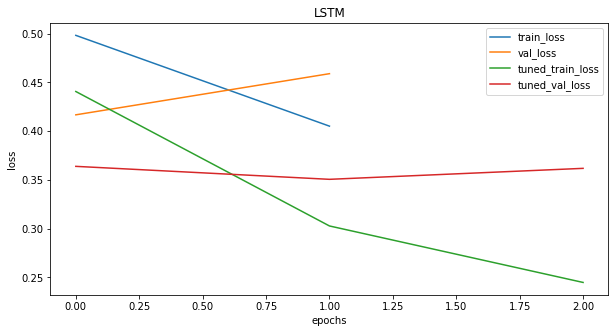

In [185]:
plt.figure(figsize=(10,5))
plt.plot(lstm_history.history["loss"], label = "train_loss")
plt.plot(lstm_history.history["val_loss"], label = "val_loss")
plt.plot(tuned_lstm_history.history["loss"], label = "tuned_train_loss")
plt.plot(tuned_lstm_history.history["val_loss"], label = "tuned_val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("LSTM")
plt.show()

사전에 학습돤 word2vec모델을 가지고 현재 데이터에 Fine-tuning을 한 결과 RNN, LSTM, Conv1D 3가지 모델 모두 val_loss값이 어느정도 감소하였으며 그 중에서 가장 val_loss값이 가장 작은 모델은 Fine-tuning이 완료된 LSTM모델이었습니다.

가장 성능이 좋게 나온 LSTM모델을 가지고 실제 테스트 데이터를 예측하여 보겠습니다.

## 9. 최적의 모델로 테스트셋 예측하기

우선 훈련 데이터셋에 적용하였던 전처리 과정을 테스트 데이터셋에도 적용하겠습니다.

In [206]:
test_data = pd.read_table("./data/ratings_test.txt")
test_data = test_data.drop_duplicates("document", keep="first")
test_data = test_data[train_data["document"].isnull() == False]
test_data = test_data.dropna()
test_data = test_data.reset_index().drop(columns = ["index"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [207]:
tqdm.pandas()
test_data["tokenization"] = test_data["document"].progress_apply(lambda x : tokenization(x, tokenizer))

100%|██████████| 49157/49157 [00:05<00:00, 8286.07it/s]


In [208]:
test_data["token_length"] = test_data["tokenization"].apply(lambda x: len(x))

token_test_data = test_data.loc[(test_data["token_length"] > 0), :]
token_test_data = token_test_data.reset_index().drop(columns=["index"])
print(f"비어있는 데이터 제거 후 데이터 개수 : {len(token_test_data)}")

비어있는 데이터 제거 후 데이터 개수 : 49104


In [211]:
test_token = token_test_data["tokenization"] 
padded_test_data = text_sequence(test_token, maxlen, len(word_index))
padded_test_data

array([[   0,    0,    0, ...,    0,  480,   77],
       [   0,    0,    0, ...,    0,    0,    2],
       [   0,    0,    0, ..., 3687,   66,  896],
       ...,
       [   0,    0,    0, ...,    7,   11, 1509],
       [   0,    0,    0, ...,   64,  303,   41],
       [   0,    0,    0, ...,  166,   63, 1061]], dtype=int32)

전처리가 완료된 테스트셋을 가장 성능이 좋게 나온 LSTM모델에 넣어서 결과를 확인하겠습니다.

In [219]:
test_x = padded_test_data
test_y = token_test_data["label"].to_numpy()

test_loss, test_accuracy = lstm_model.evaluate(test_x, test_y)
tuned_test_loss, tuned_test_accuracy = tuned_lstm_model.evaluate(test_x, test_y)

1535/1535 [==============================] - 48s 31ms/step - loss: 0.3537 - accuracy: 0.8541


In [226]:
print(f"전이학습 전 테스트셋 정확도 : {round(test_accuracy * 100, 2)}%")
print(f"전이학습 전 테스트셋 loss : {test_loss}")
print(f"전이학습 후 테스트셋 정확도 : {round(tuned_test_accuracy * 100, 2)}%")
print(f"전이학습 후 테스트셋 loss : {tuned_test_loss}")

전이학습 전 테스트셋 정확도 : 75.13%
전이학습 전 테스트셋 loss : 0.46054524183273315
전이학습 후 테스트셋 정확도 : 85.41%
전이학습 후 테스트셋 loss : 0.3537302613258362


LSTM모델로 테스트셋을 예측한 결과 전이학습을 적용하기전에는 약 75%였지만 word2vec로 사전에 학습이 완료된 모델을 Embedding층에 Fine-tuning을 한 결과 약 85%의 정확도를 보였으며 10%정도 성능이 향상되었습니다.